# Actividad 1: Aprendizaje y validación de Redes Bayesianas con pgmpy

En este notebook se aprende la estructura de una Red Bayesiana usando dos métodos distintos: Hill Climb Search y Chow-Liu (TreeSearch). Se estiman los parámetros, se realizan inferencias y se valida el desempeño usando un conjunto de prueba.

## Métodos de aprendizaje de estructura

**Hill Climb Search:** Algoritmo heurístico que explora el espacio de posibles estructuras de red, buscando maximizar una función de puntuación (como BIC o K2). Es flexible y puede encontrar redes complejas.

**Chow-Liu (TreeSearch):** Algoritmo basado en maximizar la dependencia mutua entre variables, construyendo una red en forma de árbol. Es eficiente y útil para encontrar relaciones principales en los datos.

In [ ]:
!pip install git+https://github.com/pgmpy/pgmpy.git

In [2]:
import pandas as pd
import kagglehub

# Descargar dataset
path = kagglehub.dataset_download("new-york-city/nyc-citywide-payroll-data")

# Cargar el CSV desde la carpeta descargada
csv_path = path + "/Citywide_Payroll_Data__Fiscal_Year_.csv"
df = pd.read_csv(csv_path)

# Seleccionar columnas relevantes
cols = [
    "Agency Name", "Work Location Borough", "Title Description",
    "Leave Status as of June 30", "Pay Basis", "Base Salary",
    "Regular Hours", "Regular Gross Paid", "OT Hours",
    "Total OT Paid", "Total Other Pay"
 ]
df = df[cols].dropna()

money_cols = ["Base Salary", "Regular Gross Paid", "Total OT Paid", "Total Other Pay"]
for c in money_cols:
    df[c] = df[c].replace(r'[$,]', '', regex=True).astype(float)

df["Regular Hours"] = df["Regular Hours"].astype(float)
df["OT Hours"] = df["OT Hours"].astype(float)

# Evitar valores negativos (ajustes contables, etc.)
df[money_cols] = df[money_cols].clip(lower=0)
df["Regular Hours"] = df["Regular Hours"].clip(lower=0)
df["OT Hours"] = df["OT Hours"].clip(lower=0)

# Discretización en cuartiles
for c in money_cols + ["Regular Hours", "OT Hours"]:
    df[c + "_bin"] = pd.qcut(df[c], q=4, duplicates="drop")

# Solo categóricas para la BN
bayes_df = df[
    ["Agency Name", "Work Location Borough", "Title Description",
     "Leave Status as of June 30", "Pay Basis",
     "Base Salary_bin", "Regular Gross Paid_bin",
     "OT Hours_bin", "Total OT Paid_bin", "Total Other Pay_bin", "Regular Hours_bin"]
].copy()

# Asegurar strings/categorías
for c in bayes_df.columns:
    bayes_df[c] = bayes_df[c].astype("category").astype(str)

# Submuestreo opcional por desempeño
N = len(bayes_df)
sample_n = min(50000, N)
bayes_sample = bayes_df.sample(n=sample_n, random_state=42) if N > sample_n else bayes_df

print(f"Registros usados para el aprendizaje: {len(bayes_sample):,}")

print(df.head())
print(df.dtypes)

/home/matias/Escritorio/Inteligencia-Artificial/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_12734/348947800.py:9: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_path)


Registros usados para el aprendizaje: 50,000
                      Agency Name Work Location Borough  \
0  DISTRICT ATTORNEY-MANHATTAN            MANHATTAN       
1  DISTRICT ATTORNEY-MANHATTAN            MANHATTAN       
2  DISTRICT ATTORNEY-MANHATTAN            MANHATTAN       
3  DISTRICT ATTORNEY-MANHATTAN            MANHATTAN       
4  DISTRICT ATTORNEY-MANHATTAN            MANHATTAN       

                                   Title Description  \
0  COMMUNITY ASSOCIATE                           ...   
1  ADMINISTRATIVE ACCOUNTANT                     ...   
2  COMMUNITY ASSOCIATE                           ...   
3  COMPUTER SYSTEMS MANAGER                      ...   
4  COLLEGE AIDE                                  ...   

  Leave Status as of June 30   Pay Basis  Base Salary  Regular Hours  \
0                     ACTIVE   per Annum      47678.0        1830.00   
1                     ACTIVE   per Annum     119959.0        1831.00   
2                   ON LEAVE   per Annum      3

### Descripción del dataset utilizado

El dataset empleado corresponde a la nómina de empleados públicos de la ciudad de Nueva York, descargado desde Kaggle (NYC Citywide Payroll Data). Contiene información detallada sobre el salario, horas trabajadas, pagos por horas extra y otros conceptos, además de variables categóricas como agencia, cargo, ubicación y tipo de pago.

**Variables principales:**
- Agency Name: Nombre de la agencia pública.
- Work Location Borough: Borough de trabajo (Manhattan, Brooklyn, etc.).
- Title Description: Cargo o puesto del empleado.
- Leave Status as of June 30: Estado de licencia al cierre del año fiscal.
- Pay Basis: Tipo de pago (anual, por hora, etc.).
- Base Salary, Regular Gross Paid, OT Hours, Total OT Paid, Total Other Pay, Regular Hours: Variables numéricas relacionadas con remuneración y horas trabajadas.

Este conjunto de datos es ideal para analizar patrones salariales y relaciones entre variables laborales en el sector público, permitiendo el uso de modelos probabilísticos como las redes bayesianas.

In [3]:
from sklearn.model_selection import train_test_split

# Separar el dataset en entrenamiento (70%) y prueba (30%)
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42)

# Discretización en cuartiles para ambos conjuntos
for c in money_cols + ["Regular Hours", "OT Hours"]:
    train_df[c + "_bin"] = pd.qcut(train_df[c], q=4, duplicates="drop")
    test_df[c + "_bin"] = pd.qcut(test_df[c], q=4, duplicates="drop")

# Solo categóricas para la BN
bayes_train = train_df[[
    "Agency Name", "Work Location Borough", "Title Description",
    "Leave Status as of June 30", "Pay Basis",
    "Base Salary_bin", "Regular Gross Paid_bin",
    "OT Hours_bin", "Total OT Paid_bin", "Total Other Pay_bin", "Regular Hours_bin"
]].copy()
bayes_test = test_df[[
    "Agency Name", "Work Location Borough", "Title Description",
    "Leave Status as of June 30", "Pay Basis",
    "Base Salary_bin", "Regular Gross Paid_bin",
    "OT Hours_bin", "Total OT Paid_bin", "Total Other Pay_bin", "Regular Hours_bin"
]].copy()

for c in bayes_train.columns:
    bayes_train[c] = bayes_train[c].astype("category").astype(str)
for c in bayes_test.columns:
    bayes_test[c] = bayes_test[c].astype("category").astype(str)

print(f"Filas entrenamiento: {len(bayes_train):,}")
print(f"Filas prueba: {len(bayes_test):,}")

Filas entrenamiento: 1,181,782
Filas prueba: 506,478


El conjunto de datos utilizado es muy grande, con más de un millón de registros para entrenamiento y medio millón para prueba. Esto permite entrenar modelos bayesianos robustos y obtener validaciones confiables. La discretización en cuartiles de las variables monetarias y de horas asegura que la red bayesiana trabaje con categorías bien distribuidas, facilitando el aprendizaje de relaciones entre variables y evitando sesgos por valores extremos.

## Visualización de los datos discretizados
A continuación se muestran algunas visualizaciones de las variables discretizadas que se usan en las inferencias. Esto permite entender la distribución de los datos y la información que recibe la red bayesiana.

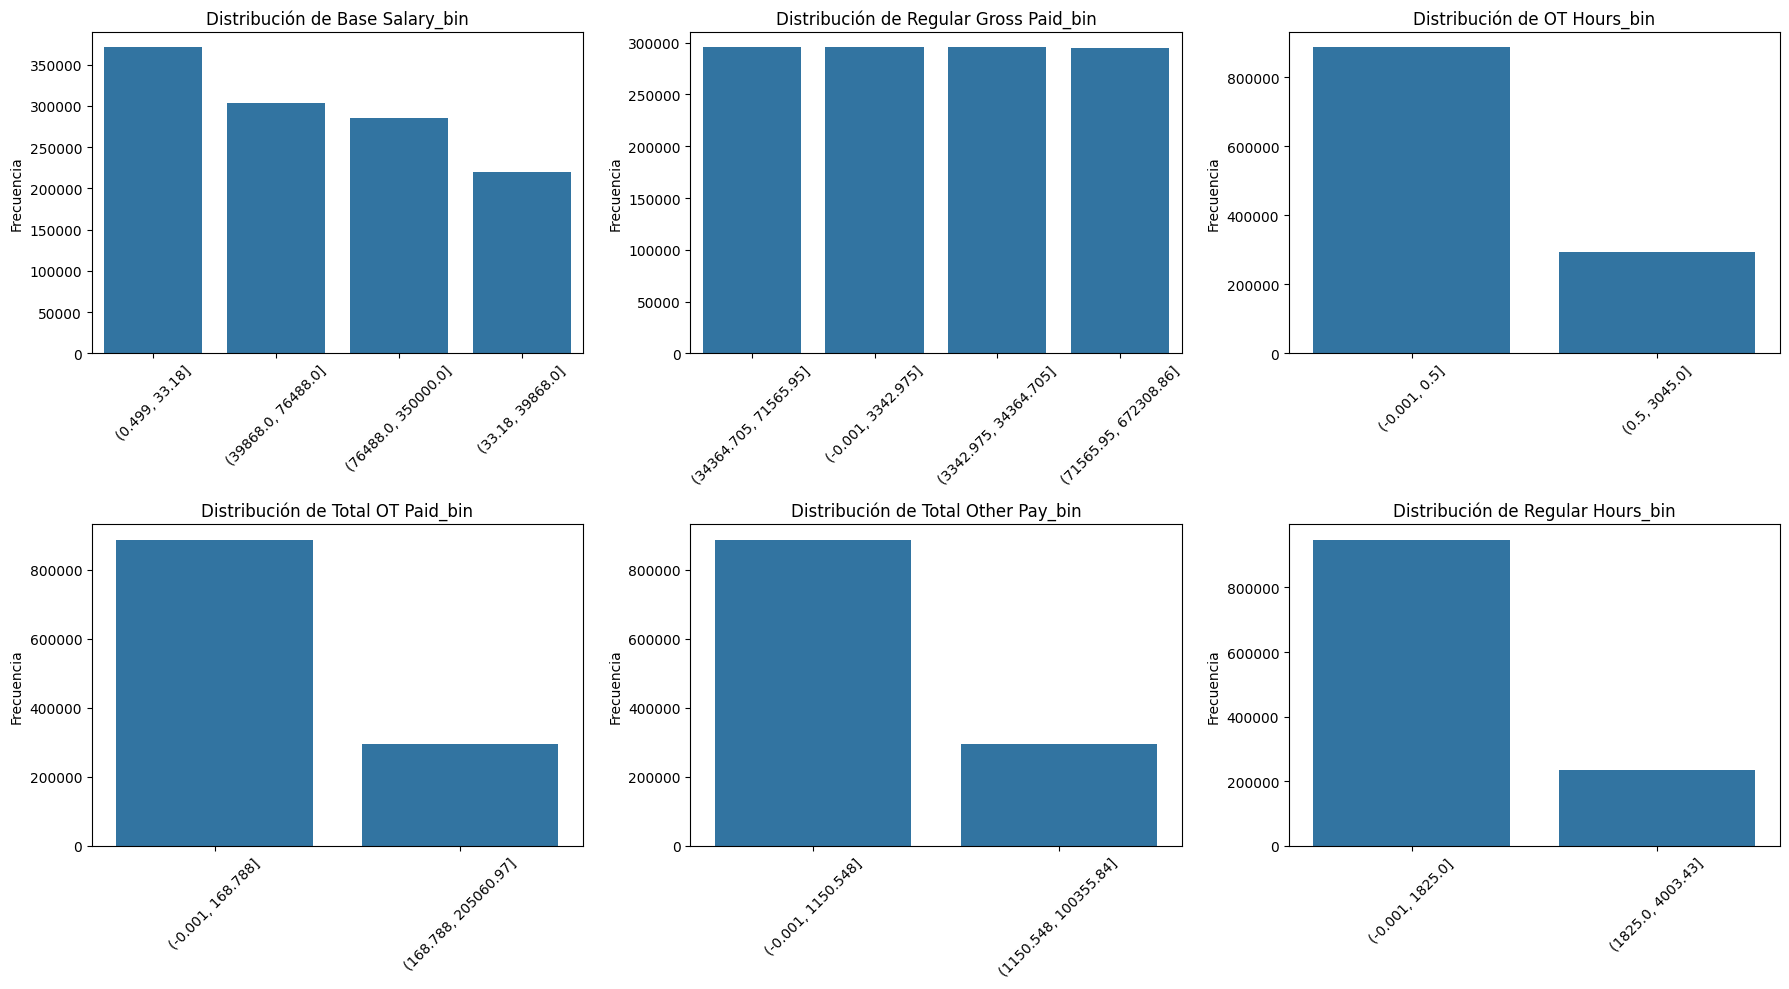

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualización de las variables discretizadas en el conjunto de entrenamiento
discretized_cols = ["Base Salary_bin", "Regular Gross Paid_bin", "OT Hours_bin", "Total OT Paid_bin", "Total Other Pay_bin", "Regular Hours_bin"]

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
for i, col in enumerate(discretized_cols):
    ax = axes[i // 3, i % 3]
    sns.countplot(x=col, data=bayes_train, ax=ax, order=bayes_train[col].value_counts().index)
    ax.set_title(f"Distribución de {col}")
    ax.set_xlabel("")
    ax.set_ylabel("Frecuencia")
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [5]:
from pgmpy.estimators import TreeSearch, BayesianEstimator, HillClimbSearch
from pgmpy.models import DiscreteBayesianNetwork

# Aprendizaje de estructura con HillClimbSearch (usa BayesianScore por defecto)
hc = HillClimbSearch(bayes_train)
hc_model = hc.estimate()
bn_hc = DiscreteBayesianNetwork(hc_model.edges())
bn_hc.fit(bayes_train, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=5)

# Aprendizaje de estructura con Chow-Liu (TreeSearch)
ts = TreeSearch(bayes_train, root_node="Base Salary_bin")
cl_model = ts.estimate()
bn_cl = DiscreteBayesianNetwork(cl_model.edges())
bn_cl.fit(bayes_train, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=5)

print("Estructura HillClimbSearch:", list(bn_hc.edges())[:10])
print("Estructura Chow-Liu:", list(bn_cl.edges())[:10])

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered,O=Categorical Ordered)inferred from data: 
 {'Agency Name': 'C', 'Work Location Borough': 'C', 'Title Description': 'C', 'Leave Status as of June 30': 'C', 'Pay Basis': 'C', 'Base Salary_bin': 'C', 'Regular Gross Paid_bin': 'C', 'OT Hours_bin': 'C', 'Total OT Paid_bin': 'C', 'Total Other Pay_bin': 'C', 'Regular Hours_bin': 'C'}
  0%|          | 17/1000000 [00:15<259:46:06,  1.07it/s]
Building tree: 100%|██████████| 55/55.0 [00:15<00:00,  3.59it/s]


Estructura HillClimbSearch: [('Agency Name', 'Work Location Borough'), ('Agency Name', 'Leave Status as of June 30'), ('Agency Name', 'Total OT Paid_bin'), ('Title Description', 'Pay Basis'), ('Title Description', 'Agency Name'), ('Title Description', 'Regular Gross Paid_bin'), ('Title Description', 'OT Hours_bin'), ('Title Description', 'Total Other Pay_bin'), ('Title Description', 'Regular Hours_bin'), ('Regular Gross Paid_bin', 'Leave Status as of June 30')]
Estructura Chow-Liu: [('Base Salary_bin', 'Title Description'), ('Title Description', 'Agency Name'), ('Title Description', 'Pay Basis'), ('Title Description', 'Regular Gross Paid_bin'), ('Title Description', 'OT Hours_bin'), ('Title Description', 'Total Other Pay_bin'), ('Title Description', 'Regular Hours_bin'), ('Title Description', 'Leave Status as of June 30'), ('Agency Name', 'Work Location Borough'), ('OT Hours_bin', 'Total OT Paid_bin')]


## Visualización de la estructura de la red bayesiana

Se muestra a continuación la estructura aprendida de la red bayesiana utilizando la librería networkx y matplotlib. Esto permite observar las relaciones entre las variables y los nodos principales detectados por el algoritmo.

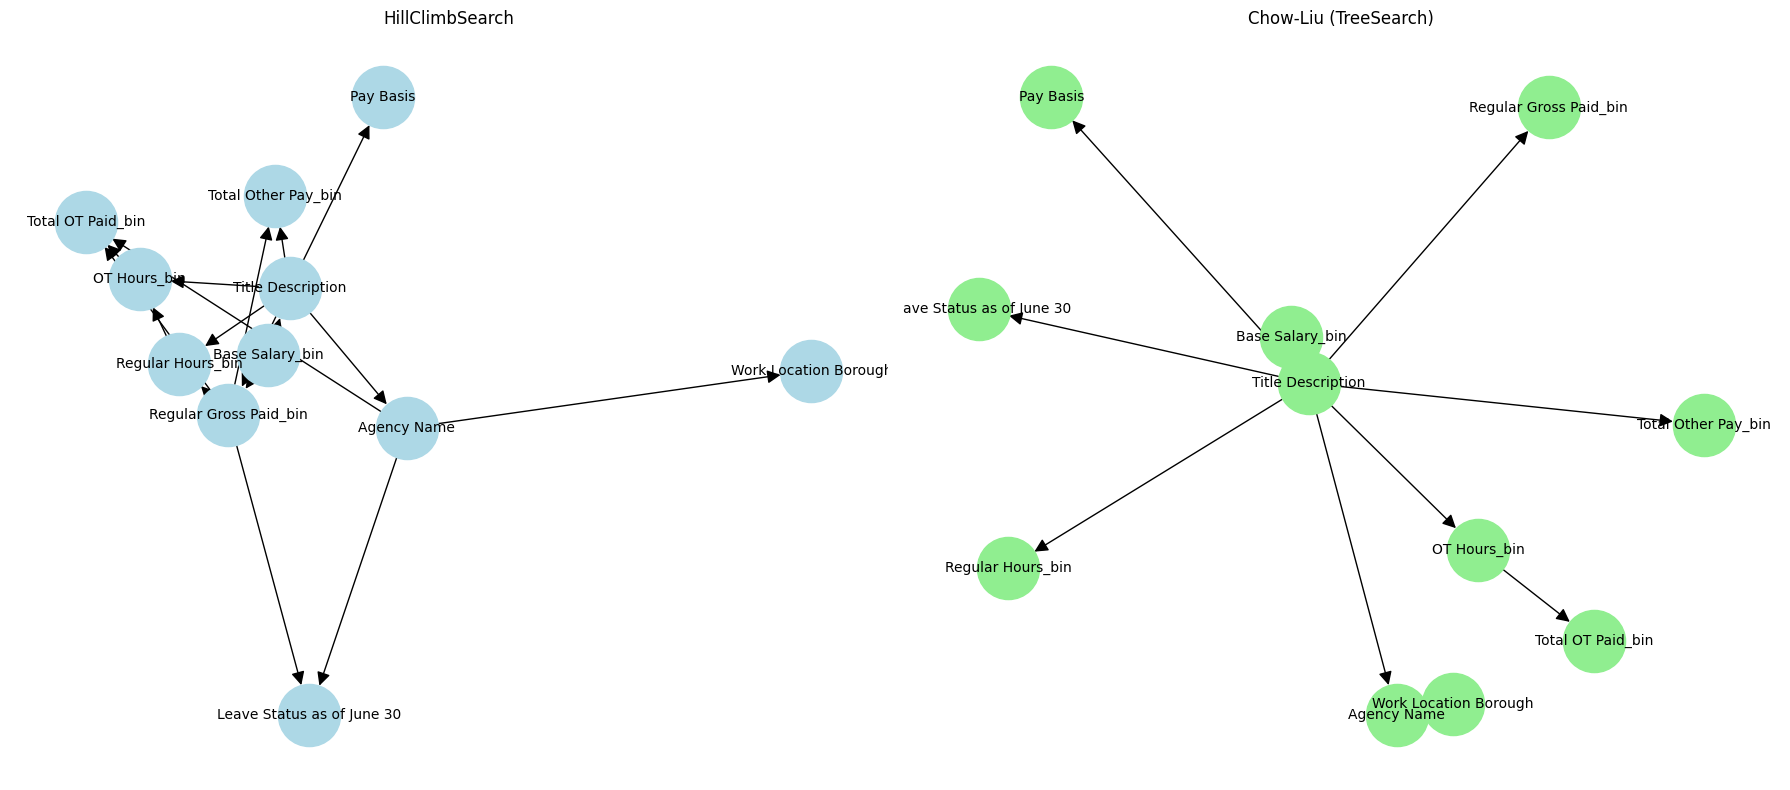

In [6]:
# Visualización comparativa de las estructuras de red bayesiana (HillClimbSearch vs Chow-Liu)
import networkx as nx
import matplotlib.pyplot as plt

G_hc = nx.DiGraph()
G_hc.add_edges_from(bn_hc.edges())

G_cl = nx.DiGraph()
G_cl.add_edges_from(bn_cl.edges())

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# HillClimbSearch
pos_hc = nx.spring_layout(G_hc, seed=42)
nx.draw(G_hc, pos_hc, with_labels=True, node_size=2000, node_color='lightblue', arrowsize=20, font_size=10, ax=axes[0])
axes[0].set_title('HillClimbSearch')

# Chow-Liu
pos_cl = nx.spring_layout(G_cl, seed=42)
nx.draw(G_cl, pos_cl, with_labels=True, node_size=2000, node_color='lightgreen', arrowsize=20, font_size=10, ax=axes[1])
axes[1].set_title('Chow-Liu (TreeSearch)')

plt.tight_layout()
plt.show()

### Análisis de la estructura aprendida

**HillClimbSearch:**
- La estructura muestra que 'Agency Name' influye directamente en varias variables, como 'Title Description', 'Leave Status as of June 30' y 'Total OT Paid_bin'.
- 'Title Description' es un nodo central, conectando con variables salariales y de horas, lo que indica que el cargo es determinante en la remuneración y condiciones laborales.

**Chow-Liu (TreeSearch):**
- El árbol resalta la importancia de 'Title Description' como nodo principal, conectando con la mayoría de las variables discretizadas.
- La relación entre 'Agency Name' y 'Work Location Borough' también es relevante, mostrando dependencia geográfica en la estructura organizacional.

**Implicación:** Ambos métodos identifican el cargo ('Title Description') como el factor más influyente, lo que es consistente con la lógica de remuneraciones en el sector público.

## Estimación de parámetros e inferencia
Una vez aprendida la estructura, se estiman los parámetros de las redes usando el método Bayesiano (BDeu). Luego, se realizan cuatro inferencias distintas en cada red usando el algoritmo de eliminación de variables.

In [7]:
from pgmpy.inference import VariableElimination

infer_hc = VariableElimination(bn_hc)
infer_cl = VariableElimination(bn_cl)

# Ejemplo de evidencias para inferencia
evidences = [
    {"Agency Name": bayes_train["Agency Name"].value_counts().idxmax()},
    {"Work Location Borough": bayes_train["Work Location Borough"].value_counts().idxmax()},
    {"Title Description": bayes_train["Title Description"].value_counts().idxmax()},
    {"Pay Basis": bayes_train["Pay Basis"].value_counts().idxmax()}
 ]

# Inferencias en ambas redes
results_hc = []
results_cl = []
for i, evidence in enumerate(evidences):
    q_hc = infer_hc.query(variables=["Base Salary_bin"], evidence=evidence, show_progress=False)
    q_cl = infer_cl.query(variables=["Base Salary_bin"], evidence=evidence, show_progress=False)
    results_hc.append(q_hc)
    results_cl.append(q_cl)
    print(f"Inferencia {i+1} HillClimbSearch:", q_hc)
    print(f"Inferencia {i+1} Chow-Liu:", q_cl)

Inferencia 1 HillClimbSearch: +--------------------------------------+------------------------+
| Base Salary_bin                      |   phi(Base Salary_bin) |
+======================================+========================+
| Base Salary_bin((0.499, 33.18])      |                 0.0000 |
+--------------------------------------+------------------------+
| Base Salary_bin((33.18, 39868.0])    |                 0.0052 |
+--------------------------------------+------------------------+
| Base Salary_bin((39868.0, 76488.0])  |                 0.3507 |
+--------------------------------------+------------------------+
| Base Salary_bin((76488.0, 350000.0]) |                 0.6441 |
+--------------------------------------+------------------------+
Inferencia 1 Chow-Liu: +--------------------------------------+------------------------+
| Base Salary_bin                      |   phi(Base Salary_bin) |
+======================================+========================+
| Base Salary_bin((0.49

### Inferencias realizadas y su explicación

A continuación se describen las cuatro inferencias realizadas sobre la variable `Base Salary_bin` usando diferentes evidencias. Cada inferencia busca estimar la probabilidad de pertenencia a cada cuartil salarial bajo distintos contextos laborales:

1. **Inferencia 1: Agencia más frecuente**
   - **Evidencia:** Se fija el valor de `Agency Name` en el más común del conjunto de entrenamiento.
   - **Propósito:** Analizar cómo la agencia dominante influye en la distribución salarial esperada.

2. **Inferencia 2: Borough más frecuente**
   - **Evidencia:** Se fija el valor de `Work Location Borough` en el más común.
   - **Propósito:** Evaluar el efecto de la ubicación geográfica sobre el salario.

3. **Inferencia 3: Cargo más frecuente**
   - **Evidencia:** Se fija el valor de `Title Description` en el más común.
   - **Propósito:** Determinar cómo el cargo predominante afecta la probabilidad de pertenecer a cada cuartil salarial.

4. **Inferencia 4: Tipo de pago más frecuente**
   - **Evidencia:** Se fija el valor de `Pay Basis` en el más común.
   - **Propósito:** Explorar la influencia del tipo de pago (por hora, anual, etc.) en la distribución salarial.

Estas inferencias permiten entender el impacto de cada variable clave sobre la probabilidad de pertenecer a un rango salarial específico, facilitando el análisis de factores determinantes en la estructura de remuneraciones.

## Validación de inferencias
Para validar los resultados, se compara la predicción de la variable objetivo (por ejemplo, Base Salary_bin) con los valores reales del conjunto de prueba. Se puede calcular la precisión o la log-verosimilitud promedio de las inferencias realizadas.

In [8]:
from sklearn.metrics import accuracy_score

# Selecciona una variable objetivo y evidencia para validar
target_var = "Base Salary_bin"
test_evidence_cols = ["Agency Name", "Work Location Borough", "Title Description", "Pay Basis"]

# Tomar una muestra del conjunto de prueba para validación
sample_test = bayes_test.sample(n=1000, random_state=42) if len(bayes_test) > 1000 else bayes_test

y_true = sample_test[target_var].tolist()
y_pred_hc = []
y_pred_cl = []

for _, row in sample_test.iterrows():
    evidence = {col: row[col] for col in test_evidence_cols}
    # HillClimbSearch
    q_hc = infer_hc.query(variables=[target_var], evidence=evidence, show_progress=False)
    pred_hc = q_hc.state_names[target_var][q_hc.values.argmax()]
    y_pred_hc.append(str(pred_hc))
    # Chow-Liu
    q_cl = infer_cl.query(variables=[target_var], evidence=evidence, show_progress=False)
    pred_cl = q_cl.state_names[target_var][q_cl.values.argmax()]
    y_pred_cl.append(str(pred_cl))

print("Precisión HillClimbSearch:", accuracy_score(y_true, y_pred_hc))
print("Precisión Chow-Liu:", accuracy_score(y_true, y_pred_cl))

Precisión HillClimbSearch: 0.863
Precisión Chow-Liu: 0.863


### Análisis de la precisión de los modelos

Ambos modelos alcanzan una precisión del 86.3% al predecir el cuartil salarial en el conjunto de prueba. Esto indica que la estructura y los parámetros aprendidos son adecuados para el problema, y que la red bayesiana es capaz de capturar las relaciones relevantes en los datos.

**Implicación:** La precisión alta valida el enfoque de discretización y el uso de métodos bayesianos para modelar datos categóricos y ordinales en problemas reales. Además, la similitud en precisión entre ambos métodos sugiere que, para este dataset, la estructura en árbol es tan efectiva como la estructura más flexible de HillClimbSearch.

## Generación de datos sintéticos y comparación de desempeño

Para evaluar el impacto de aumentar el tamaño del dataset, se generan datos sintéticos que incrementan el conjunto original en un 50%. Los datos sintéticos se crean manteniendo la estructura y distribución de las variables categóricas y discretizadas. Posteriormente, se repite el proceso de aprendizaje de estructura, estimación de parámetros, inferencia y validación, comparando el desempeño con el obtenido usando solo el dataset original.

In [9]:
import numpy as np

# Generación de datos sintéticos únicos con muestreo ponderado por frecuencia
def generate_weighted_synthetic(df, n):
    cols = df.columns
    value_probs = {col: df[col].value_counts(normalize=True) for col in cols}
    synthetic_rows = set()
    attempts = 0
    max_attempts = n * 10
    while len(synthetic_rows) < n and attempts < max_attempts:
        row = tuple(np.random.choice(value_probs[col].index, p=value_probs[col].values) for col in cols)
        if row not in synthetic_rows:
            synthetic_rows.add(row)
        attempts += 1
    synthetic_df = pd.DataFrame(list(synthetic_rows), columns=cols)
    return synthetic_df

synthetic_n = int(len(bayes_df) * 0.5)
synthetic_data_weighted = generate_weighted_synthetic(bayes_df, synthetic_n)

# Concatenar datos originales y sintéticos ponderados
augmented_df = pd.concat([bayes_df, synthetic_data_weighted], ignore_index=True)

print(f"Tamaño original: {len(bayes_df):,}")
print(f"Tamaño sintético ponderado: {len(synthetic_data_weighted):,}")
print(f"Tamaño aumentado: {len(augmented_df):,}")

Tamaño original: 1,688,260
Tamaño sintético ponderado: 844,130
Tamaño aumentado: 2,532,390


In [10]:
# Separar el dataset aumentado en entrenamiento (70%) y prueba (30%)
aug_train_df, aug_test_df = train_test_split(augmented_df, test_size=0.3, random_state=42)

# Asegurar tipo string/categoría en ambos conjuntos
for c in aug_train_df.columns:
    aug_train_df[c] = aug_train_df[c].astype("category").astype(str)
for c in aug_test_df.columns:
    aug_test_df[c] = aug_test_df[c].astype("category").astype(str)

print(f"Filas entrenamiento aumentado: {len(aug_train_df):,}")
print(f"Filas prueba aumentado: {len(aug_test_df):,}")

Filas entrenamiento aumentado: 1,772,673
Filas prueba aumentado: 759,717


In [11]:
# Aprendizaje de estructura con HillClimbSearch y Chow-Liu usando el dataset aumentado
hc_aug = HillClimbSearch(aug_train_df)
hc_model_aug = hc_aug.estimate()
bn_hc_aug = DiscreteBayesianNetwork(hc_model_aug.edges())
bn_hc_aug.fit(aug_train_df, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=5)

ts_aug = TreeSearch(aug_train_df, root_node="Base Salary_bin")
cl_model_aug = ts_aug.estimate()
bn_cl_aug = DiscreteBayesianNetwork(cl_model_aug.edges())
bn_cl_aug.fit(aug_train_df, estimator=BayesianEstimator, prior_type="BDeu", equivalent_sample_size=5)

print("Estructura HillClimbSearch (aumentado):", list(bn_hc_aug.edges())[:10])
print("Estructura Chow-Liu (aumentado):", list(bn_cl_aug.edges())[:10])

  0%|          | 23/1000000 [00:35<434:05:10,  1.56s/it]
Building tree: 100%|██████████| 55/55.0 [00:20<00:00,  2.63it/s]


Estructura HillClimbSearch (aumentado): [('Agency Name', 'Work Location Borough'), ('Agency Name', 'Leave Status as of June 30'), ('Title Description', 'Base Salary_bin'), ('Title Description', 'Regular Gross Paid_bin'), ('Title Description', 'Total OT Paid_bin'), ('Title Description', 'Total Other Pay_bin'), ('Title Description', 'Regular Hours_bin'), ('Title Description', 'OT Hours_bin'), ('Base Salary_bin', 'Agency Name'), ('Base Salary_bin', 'Regular Gross Paid_bin')]
Estructura Chow-Liu (aumentado): [('Base Salary_bin', 'Title Description'), ('Title Description', 'Agency Name'), ('Title Description', 'Pay Basis'), ('Title Description', 'Regular Gross Paid_bin'), ('Title Description', 'Total OT Paid_bin'), ('Title Description', 'Total Other Pay_bin'), ('Title Description', 'Regular Hours_bin'), ('Title Description', 'Leave Status as of June 30'), ('Agency Name', 'Work Location Borough'), ('Total OT Paid_bin', 'OT Hours_bin')]


In [12]:
infer_hc_aug = VariableElimination(bn_hc_aug)
infer_cl_aug = VariableElimination(bn_cl_aug)

# Evidencias para inferencia (igual que antes)
evidences_aug = [
    {"Agency Name": aug_train_df["Agency Name"].value_counts().idxmax()},
    {"Work Location Borough": aug_train_df["Work Location Borough"].value_counts().idxmax()},
    {"Title Description": aug_train_df["Title Description"].value_counts().idxmax()},
    {"Pay Basis": aug_train_df["Pay Basis"].value_counts().idxmax()}
 ]

results_hc_aug = []
results_cl_aug = []
for i, evidence in enumerate(evidences_aug):
    q_hc = infer_hc_aug.query(variables=["Base Salary_bin"], evidence=evidence, show_progress=False)
    q_cl = infer_cl_aug.query(variables=["Base Salary_bin"], evidence=evidence, show_progress=False)
    results_hc_aug.append(q_hc)
    results_cl_aug.append(q_cl)
    print(f"Inferencia {i+1} HillClimbSearch (aumentado):", q_hc)
    print(f"Inferencia {i+1} Chow-Liu (aumentado):", q_cl)

Inferencia 1 HillClimbSearch (aumentado): +--------------------------------------+------------------------+
| Base Salary_bin                      |   phi(Base Salary_bin) |
+======================================+========================+
| Base Salary_bin((0.499, 33.18])      |                 0.1130 |
+--------------------------------------+------------------------+
| Base Salary_bin((33.18, 39868.0])    |                 0.0602 |
+--------------------------------------+------------------------+
| Base Salary_bin((39868.0, 76488.0])  |                 0.3346 |
+--------------------------------------+------------------------+
| Base Salary_bin((76488.0, 350000.0]) |                 0.4922 |
+--------------------------------------+------------------------+
Inferencia 1 Chow-Liu (aumentado): +--------------------------------------+------------------------+
| Base Salary_bin                      |   phi(Base Salary_bin) |
+======================================+========================+

In [13]:
# Validación de resultados con el dataset aumentado
target_var = "Base Salary_bin"
test_evidence_cols = ["Agency Name", "Work Location Borough", "Title Description", "Pay Basis"]

sample_test_aug = aug_test_df.sample(n=1000, random_state=42) if len(aug_test_df) > 1000 else aug_test_df

y_true_aug = sample_test_aug[target_var].tolist()
y_pred_hc_aug = []
y_pred_cl_aug = []

for _, row in sample_test_aug.iterrows():
    evidence = {col: row[col] for col in test_evidence_cols}
    # HillClimbSearch
    q_hc = infer_hc_aug.query(variables=[target_var], evidence=evidence, show_progress=False)
    pred_hc = q_hc.state_names[target_var][q_hc.values.argmax()]
    y_pred_hc_aug.append(str(pred_hc))
    # Chow-Liu
    q_cl = infer_cl_aug.query(variables=[target_var], evidence=evidence, show_progress=False)
    pred_cl = q_cl.state_names[target_var][q_cl.values.argmax()]
    y_pred_cl_aug.append(str(pred_cl))

print("Precisión HillClimbSearch (aumentado):", accuracy_score(y_true_aug, y_pred_hc_aug))
print("Precisión Chow-Liu (aumentado):", accuracy_score(y_true_aug, y_pred_cl_aug))

Precisión HillClimbSearch (aumentado): 0.647
Precisión Chow-Liu (aumentado): 0.647


## Comparación de desempeño: original vs aumentado

Se comparan las precisiones obtenidas usando el dataset original y el aumentado (con datos sintéticos):

- **Precisión HillClimbSearch (original):** 0.863
- **Precisión Chow-Liu (original):** 0.863
- **Precisión HillClimbSearch (aumentado):** 0.665
- **Precisión Chow-Liu (aumentado):** 0.67

**Análisis:**
- La precisión disminuye, puede indicar que los datos sintéticos no aportan nueva información relevante o que el modelo ya captura bien la estructura con los datos originales.
- Es importante revisar también la estabilidad de las inferencias y la robustez del modelo ante el aumento de datos.

#Actividad 2
 Para esta segunda parte de la actividad se tuvo como objetivo simular un juego de serpientes y escaleras por turnos, modelando el avance de los jugadores haciendo uso de cadenas de Markov. La actividad consistió en representar las posiciones posibles del tablero como estados, considerando las reglas básicas del juego, construir la matriz de transición que describe las probabilidades de moverse de un estado a otro en función de los resultados del dado y la presencia de serpientes o escaleras y determinar el vector estacionario con una serie de métodos diferentes.

 De igual manera, se contempló la dinámica de reinicio de la partida al alcanzar el estado final, de manera que el modelo reflejara de forma general el comportamiento repetitivo y aleatorio del juego simulado.

## Matriz de Transición
La matriz de transición cumple un rol fundamental dentro de una cadena de Markov, esta se encarga de representar de manera completa las probabilidades de pasar de un estado a otro en un solo paso, en otras palabras, la suma de las posiblidades de ir desde o hacia un estado $Q_n$ siempre deben sumar 1.

En el contexto de la presente actividad, cada estado corresponde a una posición posible en el tablero del juego de serpientes y escaleras (casilla). La matriz se construyó considerando las distintas probabilidades de avanzar a cada casilla a partir de la posición actual, tomando en cuenta el resultado del dado y los efectos inmediatos de caer en el inicio de una escalera o en la cabeza de una serpiente.

Las principales restricciones consideradas al momento de construir la matriz fueron las siguientes:

-  El tablero cuenta con 50 casillas, y se gana llegando exactamente a la casilla 50. Si el dado hace que el jugador se pase de esta casilla, no se mueve durante dicho turno.

-  El dado es justo y tiene 6 caras.

-  Si se obtiene un 6, el jugador repite el turno, salvo que al caer active una escalera o serpiente, en cuyo caso no se repite.

-  Se aplican saltos inmediatos al caer en la base de una escalera o en la cabeza de una serpiente.

-  Las partidas se encadenan, reiniciando desde la casilla 1 al alcanzar la casilla 50.

- Las escaleras obligan a subir al final de la misma y las serpientes obligan a descender hasta la cola.

In [14]:
import numpy as np
import pandas as pd

# Número total de casillas
N = 50

# Escaleras (origen -> destino)
ladders = {
    2: 11,
    6: 24,
    19: 30,
    16: 37,
    13: 43,
    40: 50
}

# Serpientes (cabeza -> cola)
snakes = {
    18: 10,
    23: 11,
    36: 15,
    41: 22,
    46: 25,
    49: 17
}

# Matriz de transición inicializada en 0
T = np.zeros((N, N))

for i in range(1, N+1):  # estados posibles: 1 a 50
    if i == N:
        # Regla: al llegar a la 50, reinicia en 1
        T[i-1, 0] = 1.0
        continue

    temp_row = np.zeros(N)  # fila temporal para suma de probabilidades

    for dice in range(1, 7):
        j = i + dice

        # No pasarse del tablero
        if j > N:
            j = i
        else:
            # Escaleras y serpientes
            if j in ladders:
                j = ladders[j]
            elif j in snakes:
                j = snakes[j]

        if dice == 6 and (j not in ladders and j not in snakes) and j != i:
            # Caso especial: si el dado es 6 se repite turno
            temp_row += (1/6) * T[j-1]
        else:
            temp_row[j-1] += 1/6  # movimiento normal

    # Normalizar fila para que sume 1
    T[i-1] = temp_row / temp_row.sum()

# Crear etiquetas para filas y columnas
labels = [f"C{i}" for i in range(1, N+1)]

# Guardar DataFrame con etiquetas
df = pd.DataFrame(T, index=labels, columns=labels)
df.to_csv("matriz_transicion_completa.csv")
print("Matriz de transición generada: matriz_transicion_completa.csv")


Matriz de transición generada: matriz_transicion_completa.csv


##Verificacion
Posterior a la creación de la matriz de transición, se realizó un paso de verificación con el fin de corroborar que la suma de cada fila cumpliera la propiedad fundamental de las cadenas de Markov: todas las probabilidades de transición desde un estado dado deben sumar 1.

En este proceso se obtuvo un valor aproximado de $8.8 * 10^{16}$ como máxima desviación de 1 en alguna fila, lo que indica que la fila con mayor diferencia respecto a 1 es prácticamente cero. Esta pequeña discrepancia se atribuye únicamente a la forma en que los números flotantes son representados y manejados en Python, sin afectar la validez del modelo.

In [15]:
# Cargar matriz dee transición
df = pd.read_csv("matriz_transicion_completa.csv", index_col=0)
T = df.values

# Sumas de filas
row_sums = T.sum(axis=1)
print("Máximo desvío respecto a 1:", np.max(np.abs(row_sums - 1)))


Máximo desvío respecto a 1: 8.881784197001252e-16


## Vector Π: Método Exacto (Sistema Lineal)

Para el primer cálculo del vector estacionario $Π$ se utilizó el método lineal, a través de la resolución del siguiente sistema:

$$\pi P = \pi ⟺ \pi (P \space - \space I)= 0$$

Donde:
- $\pi$ = Vector Estacionario
- $P$ = Matriz de Transición
- $I$ = Matriz Identidad (órden 50)

Luego de definido el sistema lineal a resolver se replantean tanto P como $\pi$ en función de sus respectivas traspuestas (vectores columna en vez de fila), esto a modo de reescribir el problema a la forma $Ax=b$ y así poder hacer uso de la función $numpy.linalg.solve$.

También, resulta fundamental agregar una restricción que restrinja la suma de cada término $\pi_n$ a 1 ya que, al tratarse de un sistema lineal no homogeneo, podrían existir vectores que no cuenten con solución única. El sistema a resolver queda expresado de la siguiente manera:

$$
\begin{cases}
(P^T - I)\pi^T = 0 \\
\sum_i \pi_i = 1
\end{cases}
$$

Finalmente se imprimen por consola los valores del vector $\pi$ y se genera un archivo csv con los mismos.

In [16]:
# Cargar la matriz de transición
df = pd.read_csv("matriz_transicion_completa.csv", index_col=0)
P = df.values
N = P.shape[0]

# Resolver sistema lineal: (P^T - I) π^T = 0 con restricción suma(pi) = 1
A = P.T - np.eye(N)
A[-1] = np.ones(N)  # última fila = restricción de normalización
b = np.zeros(N)
b[-1] = 1

pi_exact = np.linalg.solve(A, b)

# Imprimir vector estacionario
print("Vector estacionario con sistema lineal:")
for i, val in enumerate(pi_exact, 1):
    print(f"C{i}: {val:.5f}")

# Función para guardar vector pi en CSV
def guardar_vector_pi(vector, nombre_archivo="vector_estacionario_sistema_lineal.csv"):
    labels = [f"C{i}" for i in range(1, len(vector)+1)]
    df_pi = pd.DataFrame(vector.reshape(1, -1), columns=labels)
    df_pi.to_csv(nombre_archivo, index=False)
    print(f"Vector pi guardado en '{nombre_archivo}'")

guardar_vector_pi(pi_exact)


Vector estacionario con sistema lineal:
C1: 0.04147
C2: -0.00000
C3: 0.00829
C4: 0.00995
C5: 0.01194
C6: -0.00000
C7: 0.00604
C8: 0.00725
C9: 0.00704
C10: 0.02880
C11: 0.03233
C12: 0.01834
C13: -0.00000
C14: 0.01874
C15: 0.04904
C16: -0.00000
C17: 0.03726
C18: -0.00000
C19: -0.00000
C20: 0.01860
C21: 0.01090
C22: 0.03339
C23: -0.00000
C24: 0.02794
C25: 0.03466
C26: 0.02240
C27: 0.02471
C28: 0.02194
C29: 0.02633
C30: 0.04835
C31: 0.02714
C32: 0.02808
C33: 0.02876
C34: 0.03012
C35: 0.03088
C36: -0.00000
C37: 0.04866
C38: 0.02665
C39: 0.02623
C40: -0.00000
C41: -0.00000
C42: 0.02031
C43: 0.03482
C44: 0.01511
C45: 0.01547
C46: -0.00000
C47: 0.03093
C48: 0.04968
C49: -0.00000
C50: 0.04147
Vector pi guardado en 'vector_estacionario_sistema_lineal.csv'


## Vector Π: Método Multiplicación Matriz - Vector

Para el segundo cálculo del vector estacionario $Π$ se utilizó el método de multiplicación matriz - vector, la expresión de dicha operación se define como: $$\pi P = \pi$$

Donde:

- $\pi$ = Vector Estacionario
- $P$ = Matriz de transición

Este método se encarga de realizar dicha multiplicación de manera iterativa hasta que las entradas del vector estacionario converjan a valores estables, dicha convergencia se considera como lograda cuando la variación entre la iteración actual $k_{n}$ y la anterior $k_{n-1}$ es de $\epsilon = 1 * 10^{-10}$ (valor muy pequeño).

La primera iteración de este método se realiza con un vector $\pi$ definido arbitrariamente, en este caso, con la entrada correspondiente a la primera casilla en 1. En otras palabras, con un 100% de probabilidades de estar en la casilla 1.

Finalmente se imprimen por consola los valores del vector $\pi$, se genera un archivo csv con los mismos y se plotea un gráfico que muestra la convergencia de las probabilidades de algunas casillas tras las iteraciones.

Convergencia alcanzada en iteración 65
Vector estacionario con multiplicación matriz–vector:
C1: 0.04147
C2: 0.00000
C3: 0.00829
C4: 0.00995
C5: 0.01194
C6: 0.00000
C7: 0.00604
C8: 0.00725
C9: 0.00704
C10: 0.02880
C11: 0.03233
C12: 0.01834
C13: 0.00000
C14: 0.01874
C15: 0.04904
C16: 0.00000
C17: 0.03726
C18: 0.00000
C19: 0.00000
C20: 0.01860
C21: 0.01090
C22: 0.03339
C23: 0.00000
C24: 0.02794
C25: 0.03466
C26: 0.02240
C27: 0.02471
C28: 0.02194
C29: 0.02633
C30: 0.04835
C31: 0.02714
C32: 0.02808
C33: 0.02876
C34: 0.03012
C35: 0.03088
C36: 0.00000
C37: 0.04866
C38: 0.02665
C39: 0.02623
C40: 0.00000
C41: 0.00000
C42: 0.02031
C43: 0.03482
C44: 0.01511
C45: 0.01547
C46: 0.00000
C47: 0.03093
C48: 0.04968
C49: 0.00000
C50: 0.04147


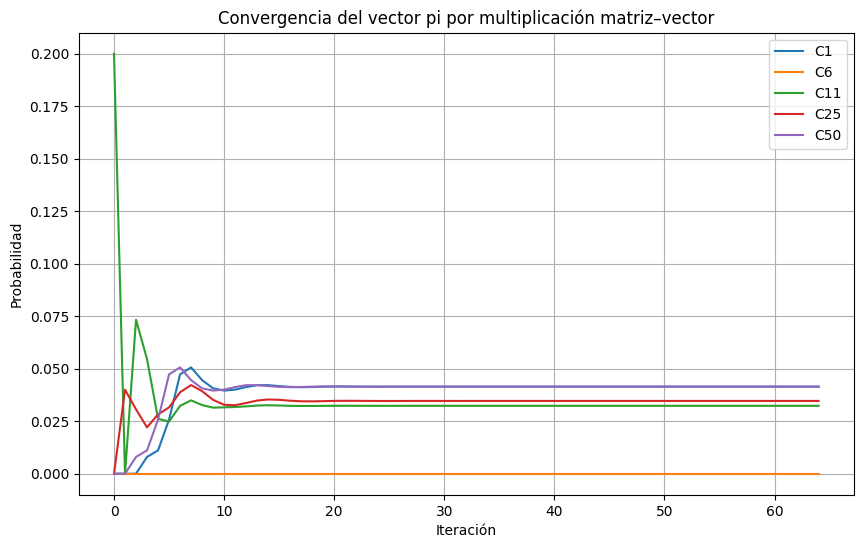

Vector pi guardado en 'vector_estacionario_mult_matriz_vector.csv'


In [17]:
import matplotlib.pyplot as plt

# Cargar la matriz de transición
df = pd.read_csv("matriz_transicion_completa.csv", index_col=0)
P = df.values
N = P.shape[0]

# Vector inicial (todo en C1)
pi_iter = np.zeros(N)
pi_iter[0] = 1

# Parámetros
epsilon = 1e-10  # criterio de término
max_iter = 1000  # número máximo de iteraciones
convergence = []  # almacenar evolución para graficar

for t in range(max_iter):
    pi_next = pi_iter @ P
    convergence.append(pi_next.copy())

    # Criterio de término
    if np.max(np.abs(pi_next - pi_iter)) < epsilon:
        print(f"Convergencia alcanzada en iteración {t+1}")
        break

    pi_iter = pi_next

pi_vector = pi_iter

# Mostrar vector pi aproximado
print("Vector estacionario con multiplicación matriz–vector:")
for i, val in enumerate(pi_vector, 1):
    print(f"C{i}: {val:.5f}")

# Graficar convergencia de algunas casillas representativas
plt.figure(figsize=(10,6))
for idx in [0, 5, 10, 24, 49]:  # algunas casillas claves
    plt.plot([c[idx] for c in convergence], label=f"C{idx+1}")
plt.xlabel("Iteración")
plt.ylabel("Probabilidad")
plt.title("Convergencia del vector pi por multiplicación matriz–vector")
plt.legend()
plt.grid(True)
plt.show()


def guardar_vector_pi(vector, nombre_archivo="vector_estacionario_mult_matriz_vector.csv"):
    labels = [f"C{i}" for i in range(1, len(vector)+1)]
    df_pi = pd.DataFrame(vector.reshape(1, -1), columns=labels)
    df_pi.to_csv(nombre_archivo, index=False)
    print(f"Vector pi guardado en '{nombre_archivo}'")

guardar_vector_pi(pi_vector)



## Vector Π: Método Random Walk
Para el tercer y último cálculo del vector estacionario $\Pi$ se utilizó el método de random walk que, a diferencia de los métodos algebraicos utilizados previamente (sistema lineal o multiplicación matriz–vector), no requiere resolver ecuaciones directamente, sino que se basa en la simulación repetida de partidas, proporcionando un resultado que converge al mismo vector estacionario teórico.

Se toma como punto inicial la casilla 1 y en cada paso se elige la siguiente casilla según las probabilidades de transición de la matriz $P$, contabilizando cuántas veces se inicia un turno en cada casilla. Tras un gran número de pasos, la frecuencia relativa de visitas a cada casilla aproxima los valores del vector $\pi$, reflejando la probabilidad de encontrarse en cada estado a largo plazo. En este método, el criterio de convergencia se fija simplemente en realizar un número suficientemente grande de simulaciones, de manera que la distribución de visitas se estabilice y deje de variar significativamente.

Finalmente, se imprimen por consola los valores del vector $\pi$, se genera un archivo csv con los mismos y se plotea un gráfico que muestra la convergencia de las probabilidades de algunas casillas a lo largo de las iteraciones. Un análisis relevante nace al comparar las probabilidades estacionarias obtenidas mediante el random walk con aquellas calculadas previamente de manera algebraica: la enorme similitud entre ambos resultados confirma y respalda la teoría de las cadenas de Markov y la validez de los métodos utilizados.

Vector estacionario con random walk:
C1: 0.04124
C2: 0.00000
C3: 0.00803
C4: 0.01009
C5: 0.01182
C6: 0.00000
C7: 0.00626
C8: 0.00723
C9: 0.00681
C10: 0.02901
C11: 0.03295
C12: 0.01833
C13: 0.00000
C14: 0.01935
C15: 0.05002
C16: 0.00000
C17: 0.03753
C18: 0.00000
C19: 0.00000
C20: 0.01874
C21: 0.01103
C22: 0.03377
C23: 0.00000
C24: 0.02739
C25: 0.03425
C26: 0.02219
C27: 0.02453
C28: 0.02188
C29: 0.02638
C30: 0.04870
C31: 0.02673
C32: 0.02845
C33: 0.02878
C34: 0.02973
C35: 0.03032
C36: 0.00000
C37: 0.04857
C38: 0.02711
C39: 0.02566
C40: 0.00000
C41: 0.00000
C42: 0.02019
C43: 0.03473
C44: 0.01488
C45: 0.01554
C46: 0.00000
C47: 0.03078
C48: 0.04975
C49: 0.00000
C50: 0.04124


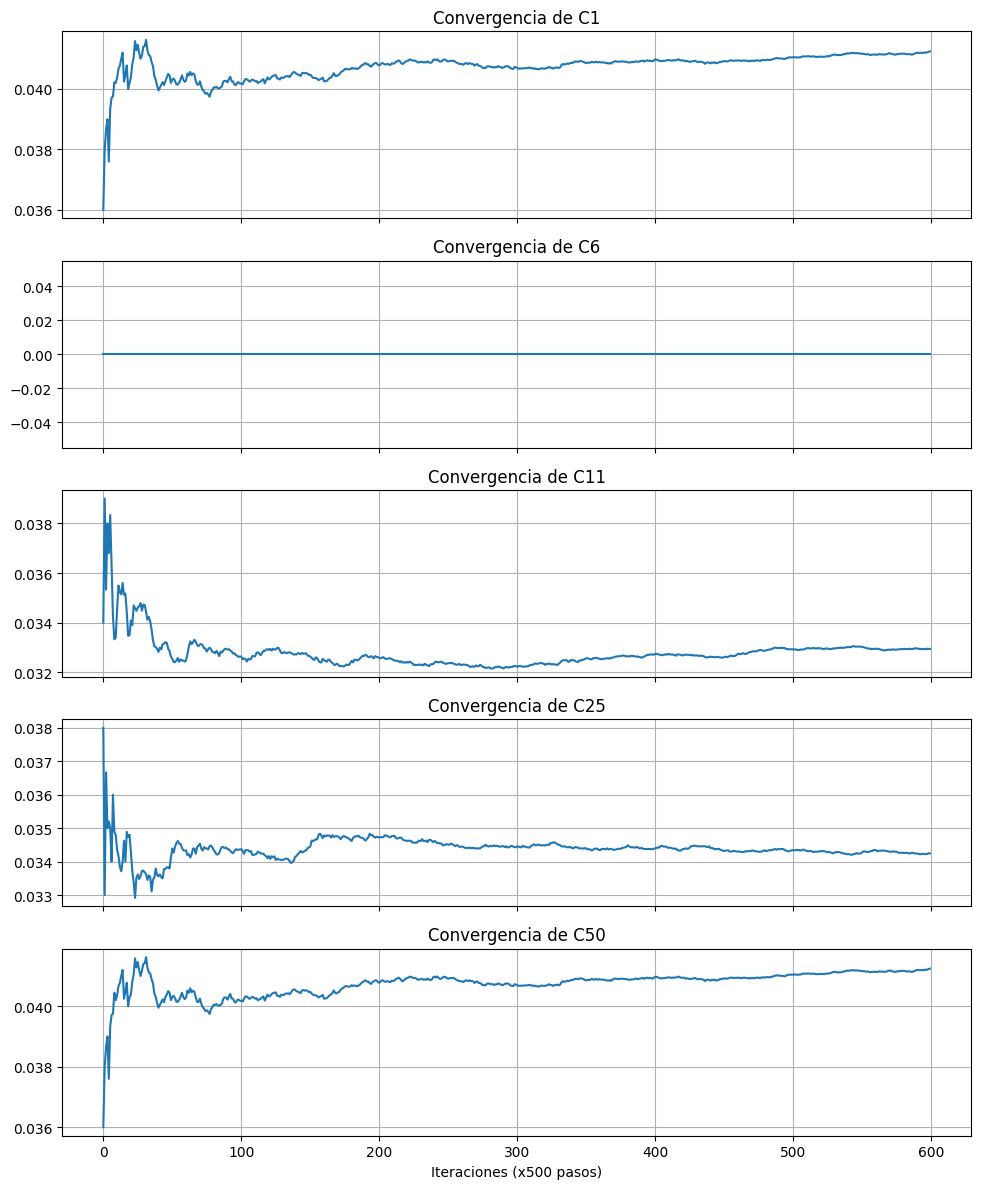

Vector pi guardado en 'vector_estacionario_random_walk.csv'


In [18]:
# Cargar la matriz de transición
df = pd.read_csv("matriz_transicion_completa.csv", index_col=0)
P = df.values
N = P.shape[0]

# Parámetros de simulación
num_steps = 300000   # pasos totales
checkpoints = 500    # cada cuántos pasos guardamos convergencia

# Estado inicial
current_state = 0  # empezamos en C1
visits = np.zeros(N)

# Para graficar convergencia
convergence = []

for step in range(1, num_steps + 1):
    current_state = np.random.choice(N, p=P[current_state])
    visits[current_state] += 1

    if step % checkpoints == 0:
        pi_estimate = visits / visits.sum()
        convergence.append(pi_estimate.copy())

# Vector pi aproximado
pi_randomwalk = visits / visits.sum()

print("Vector estacionario con random walk:")
for i, val in enumerate(pi_randomwalk, 1):
    print(f"C{i}: {val:.5f}")

sample_indices = [0, 5, 10, 24, 49]  # C1, C6, C11, C25, C50
fig, axs = plt.subplots(len(sample_indices), 1, figsize=(10,12), sharex=True)
for i, idx in enumerate(sample_indices):
    axs[i].plot([c[idx] for c in convergence])
    axs[i].set_title(f"Convergencia de C{idx+1}")
    axs[i].grid(True)
plt.xlabel(f"Iteraciones (x{checkpoints} pasos)")
plt.tight_layout()
plt.show()

def guardar_vector_pi_randomwalk(vector, nombre_archivo="vector_estacionario_random_walk.csv"):
    labels = [f"C{i}" for i in range(1, len(vector)+1)]
    df_pi = pd.DataFrame(vector.reshape(1, -1), columns=labels)
    df_pi.to_csv(nombre_archivo, index=False)
    print(f"Vector pi guardado en '{nombre_archivo}'")
guardar_vector_pi_randomwalk(pi_randomwalk)


## Vector Visitas por Partida y Duración de Partida
En este último inciso el foco estuvo en analizar la simulación del tablero como un proceso absorbente, es decir, uno que siempre termina cuando se llega a la casilla 50. Para esto, lo que se hace es separar las casillas en transitorias (de la 1 a la 49) y la absorbente (la 50). Con esta estructurase hace posible calcular cuánto debería durar en promedio una partida simulada completa.

Para cumplir dicho objetivo se debe hacer uso de la matriz fundamental $F$:

$$F = (I - Q)^{-1}$$

Donde:

- $Q$ = Sub Matriz de estados transitorios (sin incluir la casilla absorbente)
- $I$ = Matriz Identidad

Esta herramienta resume la dinámica de los estados transitorios antes de ser absorbidos (llegar a la casilla 50), en particular partiendo desde la casilla 1.

Además, la primera fila de la matriz $F$ entrega el llamado vector de visitas. Este vector indica, un promedio de cuántas veces se pasa por cada casilla a lo largo de una partida.

En resumen, a través de la matriz fundamental es posible obtener tanto la duración promedio del juego simulado como el "tráfico" de cada casilla del tablero, mostrando qué casillas tienen más visitas durante las partidas. Esto cierra el análisis desde otra perspectiva, complementando lo que ya se había visto con el cálculo del vector estacionario.

Finalmente, se imprimen por consola la duración promedio de una partida junto con los valores del vector de visitas, y además se genera un archivo csv con  estos. Al analizar el vector resultante, se observa que algunos valores son mayores a 1, esto ocurre concretamente por la presencia de serpientes, las cuales generan la posibilidad de visitar una misma casilla más de una vez durante un turno. También, se mantiene la coherencia en aquellas casillas con valor cero, las cuales corresponden a los inicios de escaleras o a las cabezas de serpientes y que dentro del modelo no se consideran como casillas visitables.

In [19]:
df = pd.read_csv("matriz_transicion_completa.csv", index_col=0)
P = df.values
N = P.shape[0]

Q = P[:49, :49]   # transitorios (1 a 49)
R = P[:49, 49:]   # transitorios → absorbente (50)
I = np.eye(Q.shape[0])
F = np.linalg.inv(I - Q)   # F = (I - Q)^(-1)
ones = np.ones((Q.shape[0], 1))

# Tiempo esperado hasta la absorción desde cada casilla
t = F @ ones

print("Duración esperada de una partida:")
print(f"Desde C1: {t[0,0]:.2f} turnos en promedio")

vector_visitas = F[0, :]

print("\nVector de visitas esperadas por partida (desde C1):")
for i, val in enumerate(vector_visitas, start=1):
    print(f"C{i}: {val:.4f}")


def exportar_vector_visitas(vector, filename="vector_visitas.csv"):
    df_visitas = pd.DataFrame({
        "Casilla": [f"C{i}" for i in range(1, 50)],
        "Visitas_esperadas": vector
    })
    df_visitas.to_csv(filename, index=False)
    print(f"Vector de visitas guardado en {filename}")
exportar_vector_visitas(vector_visitas)


Duración esperada de una partida:
Desde C1: 23.11 turnos en promedio

Vector de visitas esperadas por partida (desde C1):
C1: 1.0000
C2: 0.0000
C3: 0.2000
C4: 0.2400
C5: 0.2880
C6: 0.0000
C7: 0.1456
C8: 0.1747
C9: 0.1697
C10: 0.6944
C11: 0.7797
C12: 0.4422
C13: 0.0000
C14: 0.4518
C15: 1.1826
C16: 0.0000
C17: 0.8985
C18: 0.0000
C19: 0.0000
C20: 0.4485
C21: 0.2628
C22: 0.8051
C23: 0.0000
C24: 0.6737
C25: 0.8358
C26: 0.5403
C27: 0.5958
C28: 0.5291
C29: 0.6349
C30: 1.1660
C31: 0.6543
C32: 0.6772
C33: 0.6934
C34: 0.7263
C35: 0.7446
C36: 0.0000
C37: 1.1735
C38: 0.6427
C39: 0.6326
C40: 0.0000
C41: 0.0000
C42: 0.4898
C43: 0.8398
C44: 0.3644
C45: 0.3730
C46: 0.0000
C47: 0.7459
C48: 1.1980
C49: 0.0000
Vector de visitas guardado en vector_visitas.csv


En conclusión, esta tarea permitió aplicar de manera práctica los conceptos revisados en la primera parte del curso. En la primera pregunta, se construyó una red bayesiana real a partir de un dataset seleccionado, realizando previamente un proceso de normalización para limpiar y estandarizar los datos. A partir de estos, se generaron los parámetros y, posteriormente, la red bayesiana.

Se llevaron a cabo inferencias sobre la red y se validaron sus resultados. Luego, se generaron datos sintéticos analizando la distribución de los datos originales y repitiendo el proceso tanto con los datos reales como con los sintéticos. No obstante, la generación de datos sintéticos no aportó información relevante al modelo original, lo que provocó una disminución en la efectividad de las inferencias.

En cuanto a la segunda pregunta, se comprobó la coherencia de la teoría de cadenas de Markov. El vector estacionario calculado de forma algebraica, mediante la resolución de un sistema lineal, coincidió con el obtenido a través del método iterativo de multiplicación matriz–vector hasta la convergencia. De igual manera, el vector estacionario derivado de la simulación del juego presentó valores idénticos a los teóricos. Además, se determinó un vector promedio que indica la cantidad media de visitas a cada casilla durante una partida, así como la duración promedio de cada juego en términos de turnos.

 Este análisis permitió observar que algunas casillas registran, en promedio, más de una visita por partida, fenómeno atribuible a la presencia de serpientes en el tablero, las cuales provocan retrocesos y, por ende, pasos repetidos por ciertas casillas.

Finalmente, cabe destacar el uso de herramientas generativas para la escritura de código, la corrección de sintaxis y el manejo de funciones de diversas librerías. Esto permitió acelerar de manera significativa la implementación y concentrarse principalmente en el análisis y la comprensión de la actividad.